In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_score, cross_validate
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

#추가
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, fbeta_score

In [38]:
train_df = pd.read_csv('../EDA/scaled_data.csv')
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df.head(1)

,TARGET,성별,차량 소유 여부,부동산 소유 여부,수입 유형,최종 학력,결혼 여부,주거 형태,휴대전화 소유 여부,이메일 소유 여부,직업,가족 구성원 수,산업군,나이,가입연수,도시구분,월간 수입
0,0,2,1,1,3,0,0,3,1,0,1,4,5,1,2,3,0


In [39]:
train_copy = train_df.copy()

In [40]:
# 어느 산업군에서 어느 직업이 연체 여부가 높은지 확인

# 직업 수, 산업군 수의 편중을 완화하기 위하여 각 직업 별 연체 여부로 연체율 확인/ 각 산업군 별 연체 여부로 연체율 확인
# 위에서 확인한 각 산업군의 연체율을 총 평균연체율(10.71%)보다 높은 산업군 15개(총 33개의 직업 중)
# 각 산업군의 연체율을 총 평균연체율(10.71%)보다 높은 직업 8개(총 19개의 직업 중)

## 종사하는 산업군의 전체 인원수를 확인하여 너무 적은 경우 제외
## 직업에 종사하는 인원수를 확인하여 너무 적은 경우 제외

# 위의 사항 고려하여 top3 산업군과 top4 직업 선정
# 이를 결합하여 1위 산업군- 1위 직업, 2위 직업, 3위 직업 ... 3위 산업군- 1위 직업, 2위 직업, 3위 직업 비교
# 어느 파생변수가 가장 유의한지 -> 그 산업군에서 그 직업이 연체율이 높다고 예측 확인

In [41]:
# 산업군 Top3 : 8(레스토랑-0.195%), 0(건설업-0.155%), 24(자영업-0.137%)
# 직업 Top4 : 15(저임금 노동자-0.237%), 12(운전자-0.150%), 17(보안업계종사자-0.149%), 5(단순노동자-0.140%)


In [42]:
# 산업군_직업 컬럼 생성 함수
def create_job_column(df, ind_value, job_value):

#    새로운 컬럼을 생성하고 특정 조건에 따라 값을 할당하는 함수

#    Parameters:
#    - df: 데이터프레임
#    - job_value: 직업 구분코드
#    - ind_value : 산업군 구분코드

#    Returns:
#    - df: 새로운 컬럼을 추가한 데이터프레임
  # 특정 숫자에 대응하는 문자열 매핑
  ind_mapping = {8: 'rest', 0: 'cons', 24: 'bus'}  # 예시: 숫자 1, 2, 3에 각각 A, B, C 매핑
  job_mapping = {15: 'low', 12: 'drv', 17: 'sec', 5: 'lab'}  # 예시: 숫자 1, 2, 3에 각각 X, Y, Z 매핑

  # 특정 숫자에 해당하는 문자열 매핑 적용
  ind_str = ind_mapping.get(ind_value, f"default_{ind_value}")
  job_str = job_mapping.get(job_value, f"default_{job_value}")

  new_column_name = f"{ind_str}_{job_str}"
  # 조건에 맞는 행에 1을 할당하여 새로운 컬럼에 추가
  df[new_column_name] = (df['산업군'] == ind_value) & (df['직업'] == job_value)
  # True/False를 1/0으로 변환
  df[new_column_name] = df[new_column_name].astype(int)
    
  return df
# 함수 사용 예시
# create_job_column(your_df, ind_value, job_value)

In [43]:
# 산업군 8_직업 컬럼 생성
create_job_column(train_copy, 8, 15)
create_job_column(train_copy, 8, 12)
create_job_column(train_copy, 8, 17)
create_job_column(train_copy, 8, 5)

,TARGET,성별,차량 소유 여부,부동산 소유 여부,수입 유형,최종 학력,결혼 여부,주거 형태,휴대전화 소유 여부,이메일 소유 여부,...,가족 구성원 수,산업군,나이,가입연수,도시구분,월간 수입,rest_low,rest_drv,rest_sec,rest_lab
0,0,2,1,1,3,0,0,3,1,0,...,4,5,1,2,3,0,0,0,0,0
1,0,1,1,0,1,1,0,3,1,0,...,2,16,2,1,1,3,0,0,0,0
2,0,2,0,1,1,0,0,3,1,0,...,2,16,1,1,1,1,0,0,0,0
3,0,2,1,0,2,0,0,3,1,0,...,3,17,1,1,3,2,0,0,0,0
4,0,2,0,1,1,0,0,3,1,0,...,2,16,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59984,0,2,0,1,3,0,1,3,1,0,...,1,5,3,2,1,0,0,0,0,0
59985,1,1,1,1,1,0,0,3,1,0,...,2,24,2,0,1,3,0,0,0,0
59986,1,2,0,0,1,1,1,3,1,0,...,1,22,0,1,1,2,0,0,0,0
59987,0,2,1,1,1,0,3,3,1,0,...,1,19,2,1,1,1,0,0,0,0


In [44]:
# 산업군 0_직업 컬럼 생성
create_job_column(train_copy, 0, 15)
create_job_column(train_copy, 0, 12)
create_job_column(train_copy, 0, 17)
create_job_column(train_copy, 0, 5)

,TARGET,성별,차량 소유 여부,부동산 소유 여부,수입 유형,최종 학력,결혼 여부,주거 형태,휴대전화 소유 여부,이메일 소유 여부,...,도시구분,월간 수입,rest_low,rest_drv,rest_sec,rest_lab,cons_low,cons_drv,cons_sec,cons_lab
0,0,2,1,1,3,0,0,3,1,0,...,3,0,0,0,0,0,0,0,0,0
1,0,1,1,0,1,1,0,3,1,0,...,1,3,0,0,0,0,0,0,0,0
2,0,2,0,1,1,0,0,3,1,0,...,1,1,0,0,0,0,0,0,0,0
3,0,2,1,0,2,0,0,3,1,0,...,3,2,0,0,0,0,0,0,0,0
4,0,2,0,1,1,0,0,3,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59984,0,2,0,1,3,0,1,3,1,0,...,1,0,0,0,0,0,0,0,0,0
59985,1,1,1,1,1,0,0,3,1,0,...,1,3,0,0,0,0,0,0,0,0
59986,1,2,0,0,1,1,1,3,1,0,...,1,2,0,0,0,0,0,0,0,0
59987,0,2,1,1,1,0,3,3,1,0,...,1,1,0,0,0,0,0,0,0,0


In [45]:
# 산업군 24_직업 컬럼 생성
create_job_column(train_copy, 24, 15)
create_job_column(train_copy, 24, 12)
create_job_column(train_copy, 24, 17)
create_job_column(train_copy, 24, 5)

,TARGET,성별,차량 소유 여부,부동산 소유 여부,수입 유형,최종 학력,결혼 여부,주거 형태,휴대전화 소유 여부,이메일 소유 여부,...,rest_sec,rest_lab,cons_low,cons_drv,cons_sec,cons_lab,bus_low,bus_drv,bus_sec,bus_lab
0,0,2,1,1,3,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,1,1,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,1,1,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,2,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,1,1,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59984,0,2,0,1,3,0,1,3,1,0,...,0,0,0,0,0,0,0,0,0,0
59985,1,1,1,1,1,0,0,3,1,0,...,0,0,0,0,0,0,0,1,0,0
59986,1,2,0,0,1,1,1,3,1,0,...,0,0,0,0,0,0,0,0,0,0
59987,0,2,1,1,1,0,3,3,1,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59989 entries, 0 to 59988
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   TARGET      59989 non-null  int64
 1   성별          59989 non-null  int64
 2   차량 소유 여부    59989 non-null  int64
 3   부동산 소유 여부   59989 non-null  int64
 4   수입 유형       59989 non-null  int64
 5   최종 학력       59989 non-null  int64
 6   결혼 여부       59989 non-null  int64
 7   주거 형태       59989 non-null  int64
 8   휴대전화 소유 여부  59989 non-null  int64
 9   이메일 소유 여부   59989 non-null  int64
 10  직업          59989 non-null  int64
 11  가족 구성원 수    59989 non-null  int64
 12  산업군         59989 non-null  int64
 13  나이          59989 non-null  int64
 14  가입연수        59989 non-null  int64
 15  도시구분        59989 non-null  int64
 16  월간 수입       59989 non-null  int64
 17  rest_low    59989 non-null  int32
 18  rest_drv    59989 non-null  int32
 19  rest_sec    59989 non-null  int32
 20  rest_lab    59989 non-null  

In [48]:
# 파생변수 '가족크기범주' 생성
train_copy['가족크기범주'] = pd.cut(train_copy['가족 구성원 수'], bins=[0, 2, 4,float('inf')],  
                    labels=['0','1', '2'])

In [49]:
# 데이터타입 category -> int 변경 
train_copy['가족크기범주'] = train_copy['가족크기범주'].dropna().astype(int)

In [50]:
# 파생변수 'combinedFY' 생성
# 조건 설정
conditions = [
(train_copy['가족크기범주'] == 0) & (train_copy['가입연수'] == 0),
(train_copy['가족크기범주'] == 0) & (train_copy['가입연수'] == 1),
(train_copy['가족크기범주'] == 0) & (train_copy['가입연수'] == 2),
(train_copy['가족크기범주'] == 0) & (train_copy['가입연수'] == 3),

(train_copy['가족크기범주'] == 1) & (train_copy['가입연수'] == 0),
(train_copy['가족크기범주'] == 1) & (train_copy['가입연수'] == 1),
(train_copy['가족크기범주'] == 1) & (train_copy['가입연수'] == 2),
(train_copy['가족크기범주'] == 1) & (train_copy['가입연수'] == 3),


(train_copy['가족크기범주'] == 2) & (train_copy['가입연수'] == 0),
(train_copy['가족크기범주'] == 2) & (train_copy['가입연수'] == 1),
(train_copy['가족크기범주'] == 2) & (train_copy['가입연수'] == 2),
(train_copy['가족크기범주'] == 2) & (train_copy['가입연수'] == 3),
]
# 할당할 값 설정
values = [0, 1, 2, 3, 4, 5, 6, 7, 8,9,10,11]

# np.select를 사용하여 조건에 맞는 값을 'y' 컬럼에 할당
train_copy['combinedfY'] = np.select(conditions, values, default=0)
#train_copy = train_copy.drop(['차량 소유 여부', '부동산 소유 여부', '주거 형태', '근속연수'], axis=1)
train_copy.head(2)

,TARGET,성별,차량 소유 여부,부동산 소유 여부,수입 유형,최종 학력,결혼 여부,주거 형태,휴대전화 소유 여부,이메일 소유 여부,...,cons_low,cons_drv,cons_sec,cons_lab,bus_low,bus_drv,bus_sec,bus_lab,가족크기범주,combinedfY
0,0,2,1,1,3,0,0,3,1,0,...,0,0,0,0,0,0,0,0,1,6
1,0,1,1,0,1,1,0,3,1,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
# 파생변수 'age_income' 생성
# 임금수준 & 나이활용한 파생변수
conditions1 = [
(train_copy['나이'] == 0) & (train_copy['월간 수입'] == 0),
(train_copy['나이'] == 0) & (train_copy['월간 수입'] == 1),
(train_copy['나이'] == 0) & (train_copy['월간 수입'] == 2),
(train_copy['나이'] == 0) & (train_copy['월간 수입'] == 3),

(train_copy['나이'] == 1) & (train_copy['월간 수입'] == 0),
(train_copy['나이'] == 1) & (train_copy['월간 수입'] == 1),
(train_copy['나이'] == 1) & (train_copy['월간 수입'] == 2),
(train_copy['나이'] == 1) & (train_copy['월간 수입'] == 3),

(train_copy['나이'] == 2) & (train_copy['월간 수입'] == 0),
(train_copy['나이'] == 2) & (train_copy['월간 수입'] == 1),
(train_copy['나이'] == 2) & (train_copy['월간 수입'] == 2),
(train_copy['나이'] == 2) & (train_copy['월간 수입'] == 3),

(train_copy['나이'] == 3) & (train_copy['월간 수입'] == 0),
(train_copy['나이'] == 3) & (train_copy['월간 수입'] == 1),
(train_copy['나이'] == 3) & (train_copy['월간 수입'] == 2),
(train_copy['나이'] == 3) & (train_copy['월간 수입'] == 3),

(train_copy['나이'] == 4) & (train_copy['월간 수입'] == 0),
(train_copy['나이'] == 4) & (train_copy['월간 수입'] == 1),
(train_copy['나이'] == 4) & (train_copy['월간 수입'] == 2),
(train_copy['나이'] == 4) & (train_copy['월간 수입'] == 3),

]
# 할당할 값 설정
values = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# np.select를 사용하여 조건에 맞는 값을 'y' 컬럼에 할당
train_copy['age_income'] = np.select(conditions1, values, default=0)
train_copy.head(2)

,TARGET,성별,차량 소유 여부,부동산 소유 여부,수입 유형,최종 학력,결혼 여부,주거 형태,휴대전화 소유 여부,이메일 소유 여부,...,cons_drv,cons_sec,cons_lab,bus_low,bus_drv,bus_sec,bus_lab,가족크기범주,combinedfY,age_income
0,0,2,1,1,3,0,0,3,1,0,...,0,0,0,0,0,0,0,1,6,4
1,0,1,1,0,1,1,0,3,1,0,...,0,0,0,0,0,0,0,0,1,11


In [52]:
# 파생변수 'home_shape' 생성
# 부동산 소유 여부와 주거형태 활용한 변수
conditions = [
(train_copy['부동산 소유 여부'] == 0) & (train_copy['주거 형태'] == 0),
(train_copy['부동산 소유 여부'] == 0) & (train_copy['주거 형태'] == 1),
(train_copy['부동산 소유 여부'] == 0) & (train_copy['주거 형태'] == 2),
(train_copy['부동산 소유 여부'] == 0) & (train_copy['주거 형태'] == 3),
(train_copy['부동산 소유 여부'] == 1) & (train_copy['주거 형태'] == 0),
(train_copy['부동산 소유 여부'] == 1) & (train_copy['주거 형태'] == 1),
(train_copy['부동산 소유 여부'] == 1) & (train_copy['주거 형태'] == 2),
(train_copy['부동산 소유 여부'] == 1) & (train_copy['주거 형태'] == 3),
]
# 할당할 값 설정
values = [0,1, 2, 3, 4, 5, 6, 7]
# np.select를 사용하여 조건에 맞는 값을 'y' 컬럼에 할당
train_copy['home_shape'] = np.select(conditions, values, default=0)

In [53]:
# 파생변수 'car_home' 생성
# 차량 소유 여부와 부동산 소유 여부 활용한 변수
conditions = [
(train_copy['차량 소유 여부'] == 0) & (train_copy['부동산 소유 여부'] == 0),
(train_copy['차량 소유 여부'] == 0) & (train_copy['부동산 소유 여부'] == 1),
(train_copy['차량 소유 여부'] == 1) & (train_copy['부동산 소유 여부'] == 0),
(train_copy['차량 소유 여부'] == 1) & (train_copy['부동산 소유 여부'] == 1)
]
# 할당할 값 설정
values = [0,1,2,3]
# np.select를 사용하여 조건에 맞는 값을 'y' 컬럼에 할당
train_copy['car_home'] = np.select(conditions, values, default=0)

In [54]:
# 카이제곱 검정은 파생변수가 범주형일 때 유의미한지 검증하는 대표적인 지표.
# 결과로 나온 출력에서 p-value가 0.05 미만이면서 chi2가 가장 높은 파생변수가
# 카이제곱 검정으로 봤을때 가장 의미가 있는 피쳐.

# 일단 가설을 설정했다면 그 가설에 필요한 변수만 빼서 카이제곱 검정을 돌려. 
# 그래서 0.05이상 나오면 그 가설과 파생변수는 유의미하니 사용 가능.
# 그리고 이것도 통계적 요소 대립가설을 언급하며 논리를 펼칠 것.

In [55]:
train_copy.columns

Index(['TARGET', '성별', '차량 소유 여부', '부동산 소유 여부', '수입 유형', '최종 학력', '결혼 여부',
       '주거 형태', '휴대전화 소유 여부', '이메일 소유 여부', '직업', '가족 구성원 수', '산업군', '나이',
       '가입연수', '도시구분', '월간 수입', 'rest_low', 'rest_drv', 'rest_sec', 'rest_lab',
       'cons_low', 'cons_drv', 'cons_sec', 'cons_lab', 'bus_low', 'bus_drv',
       'bus_sec', 'bus_lab', '가족크기범주', 'combinedfY', 'age_income',
       'home_shape', 'car_home'],
      dtype='object')

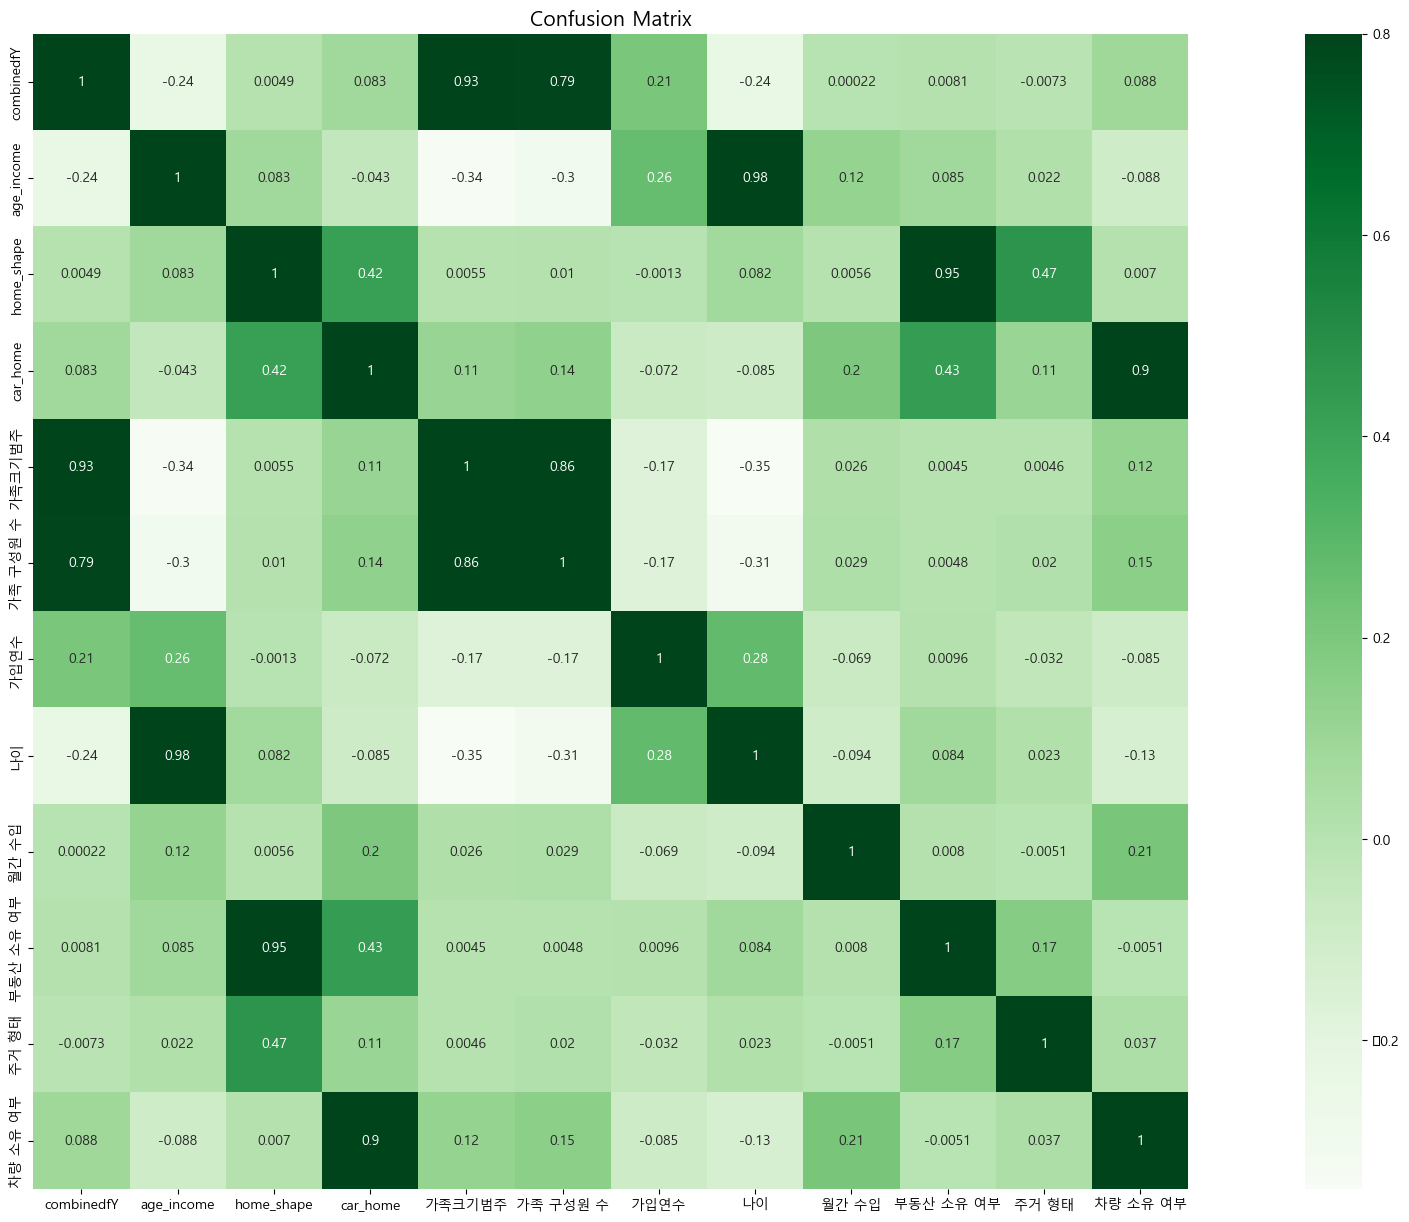

In [56]:
plt.rcParams['font.family'] = 'Malgun Gothic'
corr = train_copy[['combinedfY','age_income','home_shape','car_home', '가족크기범주', '가족 구성원 수','가입연수','나이','월간 수입','부동산 소유 여부','주거 형태','차량 소유 여부']].corr()

fig, ax = plt.subplots() 
fig.set_size_inches(30,15)
sns.heatmap(corr, vmax =.8, square = True, annot = True,cmap='Greens' )
plt.title('Confusion Matrix',fontsize=15);

In [57]:
# 다중공선성 0.7 이상으로 기준을 두고 0.7 이상인 경우 다중공선성 제거를 위해 변수 drop
# 'combinedfY'- 가족구성원수 0.79, 가족크기범주 0.93
# 'age_income'- 나이 0.98
# 'home_shape'- 부동산 소유 여부 0.95
# 'car_home'- 차량 소유여부 0.9